In [1]:
import os
from re import search

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline
from sklearn.preprocessing import quantile_transform

sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(8, 7), facecolor='white')

/mnt/md1/home/gnovakovsky/.conda/envs/pytorch_env/lib/python3.8/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
atac = sc.read_mtx('../PANCREAS/PANCREAS_FULL_MATRIX/islet.mtx')
atac = atac.transpose()

In [3]:
print(np.max(atac.X))

atac.X[atac.X>=1]=1 

print(np.max(atac.X))
print(np.min(atac.X))

37.0
1.0
0.0


In [4]:
atac.obs = pd.read_csv('../PANCREAS/PANCREAS_FULL_MATRIX/islet_snATAC.cluster_labels.txt',sep='\t', index_col=0)
atac.var = pd.read_csv('../PANCREAS/PANCREAS_FULL_MATRIX/islet.peaks', header=None)
atac.var.columns = ['peak_name']
atac.var = atac.var.set_index('peak_name')

In [5]:
atac.obs['batch'] = [s.split('_')[0] for s in atac.obs.index]

In [6]:
atac.obs.batch.unique()

array(['Islet1', 'Islet2', 'Islet3'], dtype=object)

In [7]:
import scvi
import anndata

Global seed set to 0


In [8]:
scvi.data.setup_anndata(atac,batch_key='batch')

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             


/mnt/md1/home/gnovakovsky/.conda/envs/pytorch_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


INFO     Successfully registered anndata object containing 15298 cells, 228873 vars, 3       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [9]:
pvi = scvi.model.PEAKVI(atac)
pvi.train()

pvi.save("trained_model_new", overwrite=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 83/500:  17%|█▋        | 83/500 [32:15<2:42:06, 23.33s/it, loss=1.58e+08, v_num=1]


In [10]:
pvi = scvi.model.PEAKVI.load("trained_model_new", atac)

INFO     Using data from adata.X                                                             


/mnt/md1/home/gnovakovsky/.conda/envs/pytorch_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function transfer_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.
  warnings.warn(msg, category=FutureWarning)


INFO     Registered keys:['X', 'batch_indices', 'labels']                                    
INFO     Successfully registered anndata object containing 15298 cells, 228873 vars, 3       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  


In [11]:
library_size_factor = pvi.get_library_size_factors()

<AxesSubplot:ylabel='Count'>

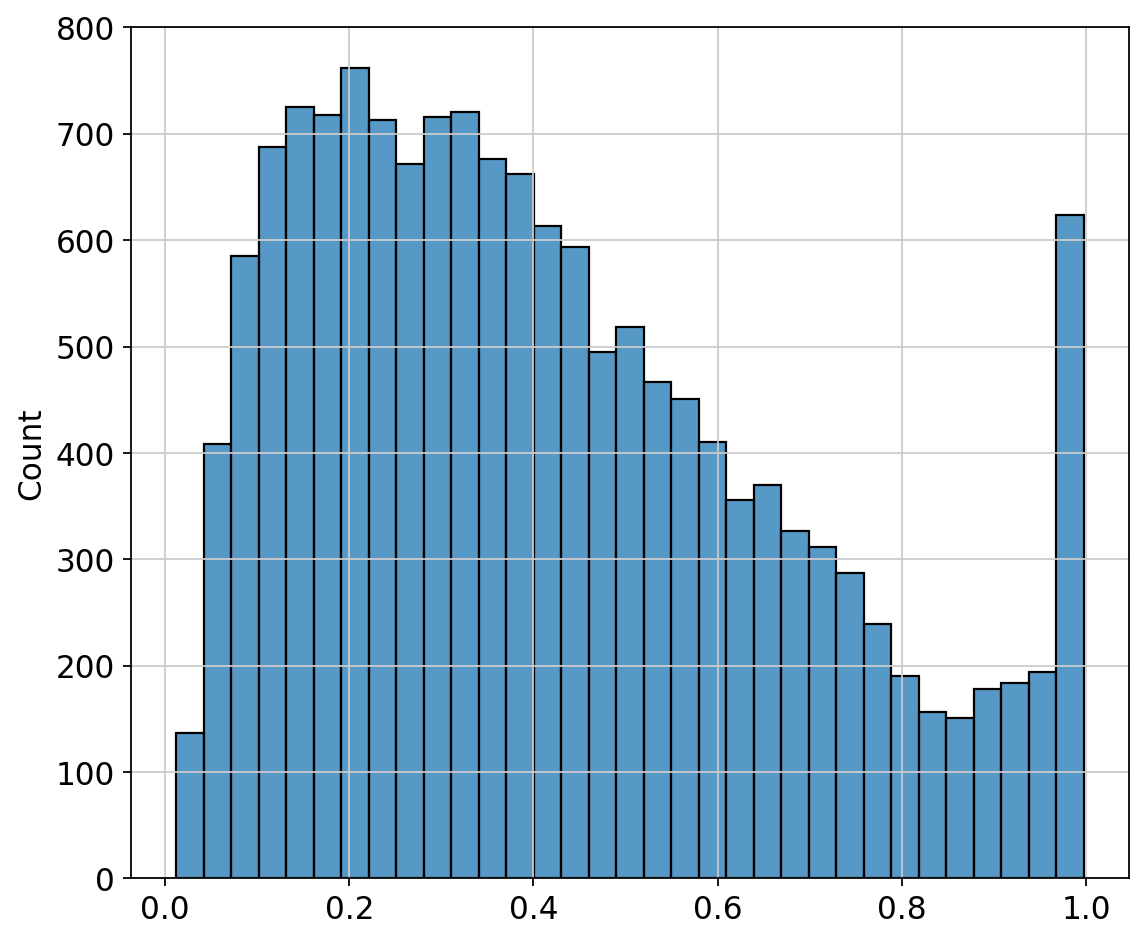

In [12]:
sns.histplot(library_size_factor)  #new 

<AxesSubplot:ylabel='Count'>

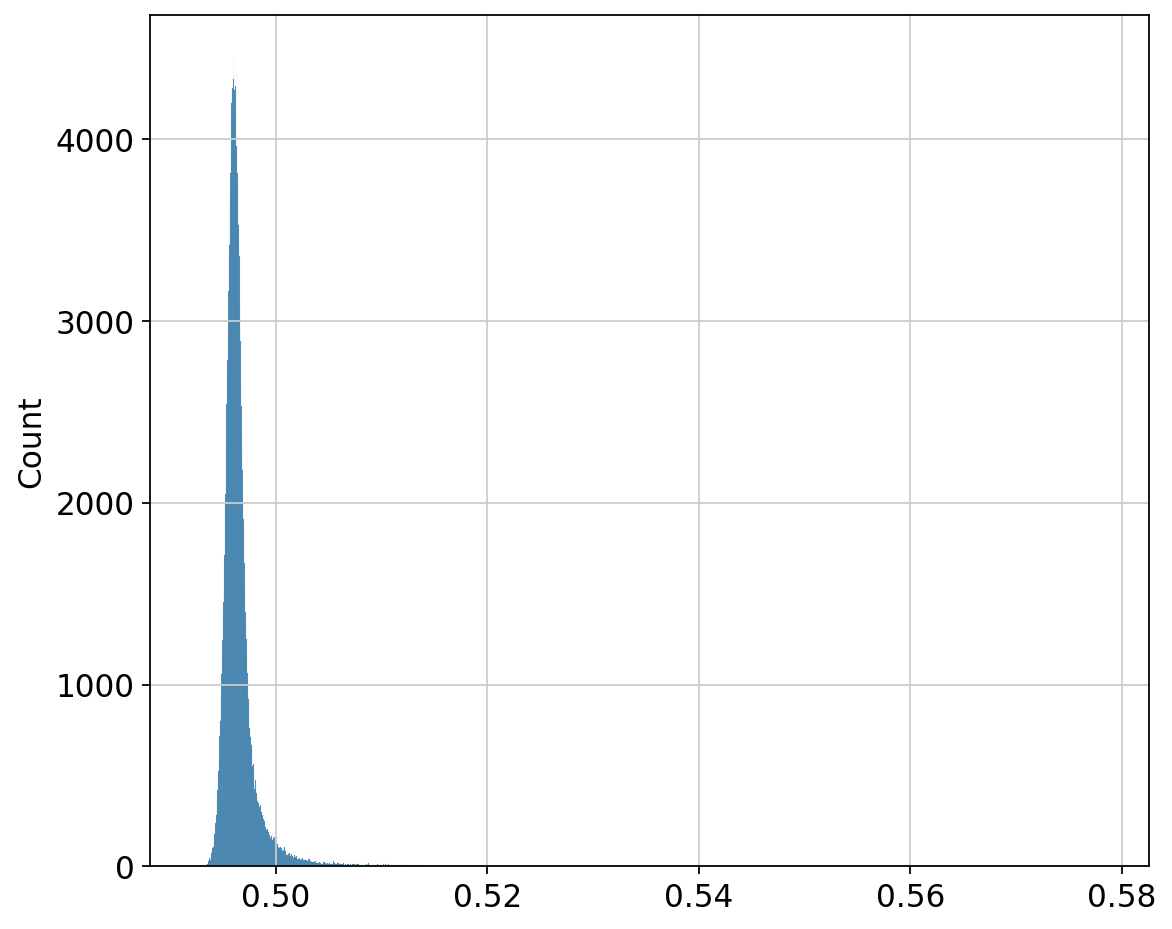

In [13]:
region_factor = pvi.get_region_factors()

df_region =pd.DataFrame(region_factor,index=atac.var.index)

df_region.to_csv('region_factor.tsv',sep='\t')

sns.histplot(region_factor)

In [14]:
latent = pvi.get_latent_representation()
atac.obsm["X_PeakVI"] = latent

print(latent.shape)

(15298, 21)


In [16]:
atac_obs = atac.obs

In [17]:
import umap
reducer = umap.UMAP(n_neighbors=20,min_dist=0.4)
#embedding = reducer.fit_transform(yy)
embedding = reducer.fit_transform(latent)
df_umap = pd.DataFrame(embedding)
df_umap.columns = ["X","Y"]
df_umap['cell_type'] = atac_obs['cluster_name'].values

In [19]:
colPalette_celltypes = ['#532C8A',
 '#c19f70',
 '#f9decf',
 '#c9a997',
 '#B51D8D',
 '#3F84AA',
 '#9e6762',
 '#354E23',
 '#F397C0',
 '#ff891c',
 '#635547',
 '#C72228']

df_umap['batch'] = atac_obs['batch'].values

<AxesSubplot:xlabel='X', ylabel='Y'>

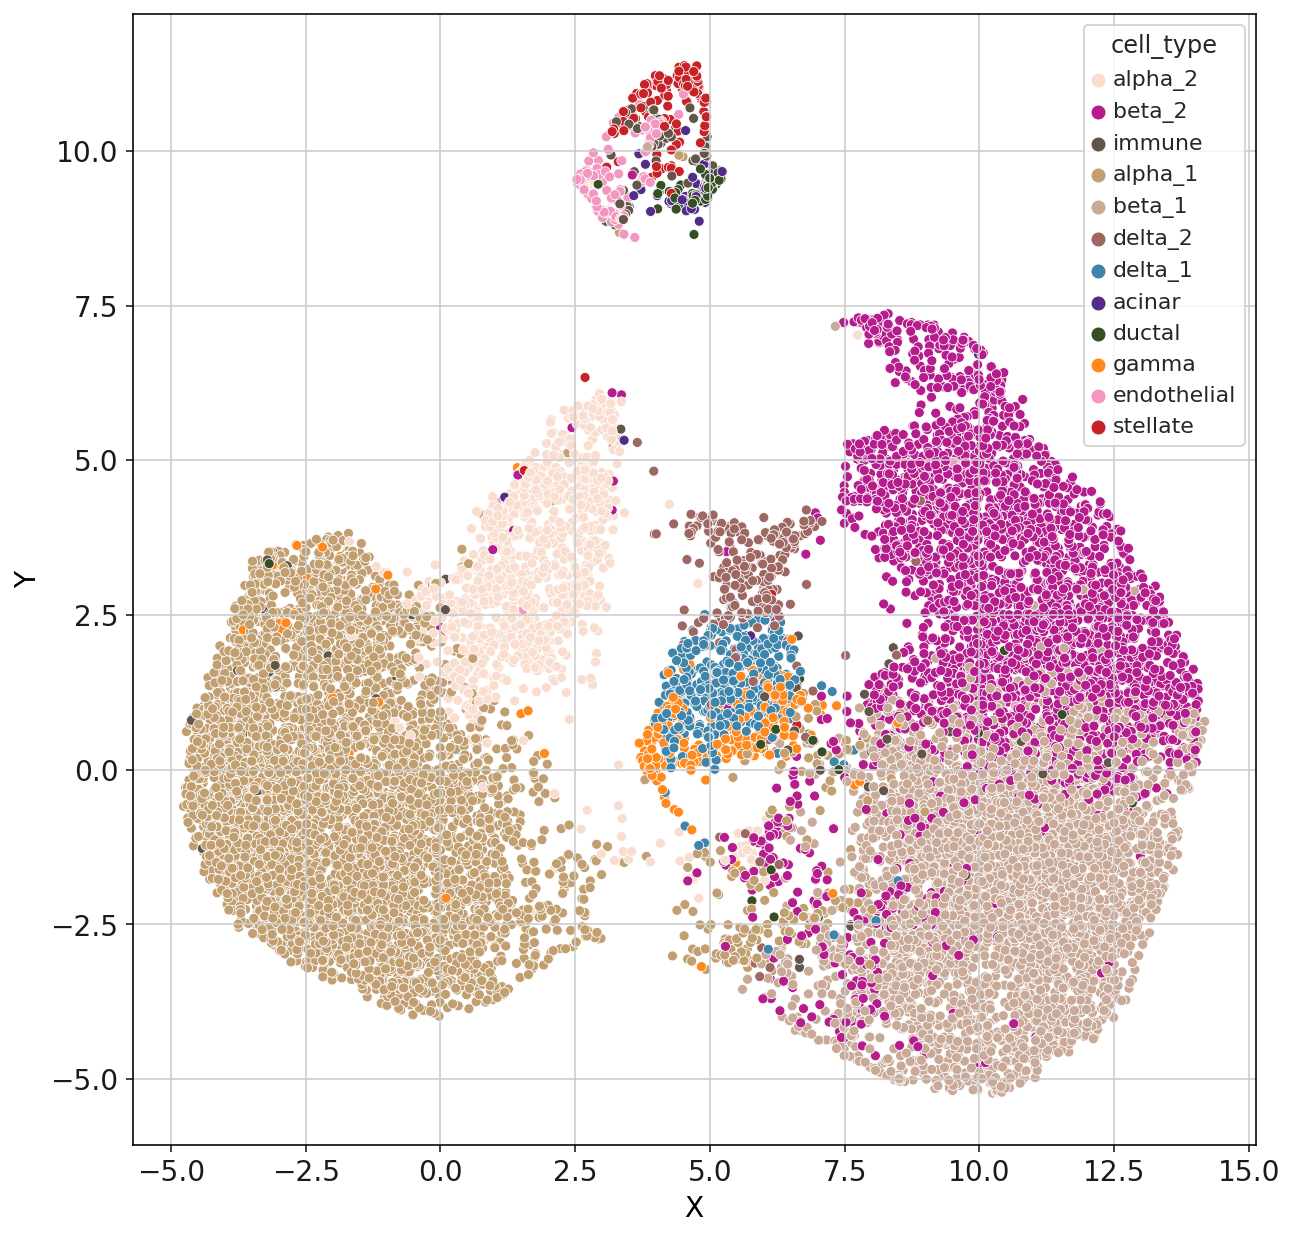

In [20]:
cell_type_sorted = sorted(list(set(atac_obs['cluster_name'].values)))
color_dict = dict(zip(cell_type_sorted,colPalette_celltypes))

%matplotlib inline
import seaborn as sns


fig, axs = plt.subplots(ncols=1, figsize=(10,10), constrained_layout=False)
sns.set(rc={'figure.figsize':(10,10)},style='whitegrid')
sns.scatterplot(x="X", y="Y",
              hue="cell_type",
              data=df_umap,palette=color_dict,ax=axs,s=25)


<AxesSubplot:xlabel='X', ylabel='Y'>

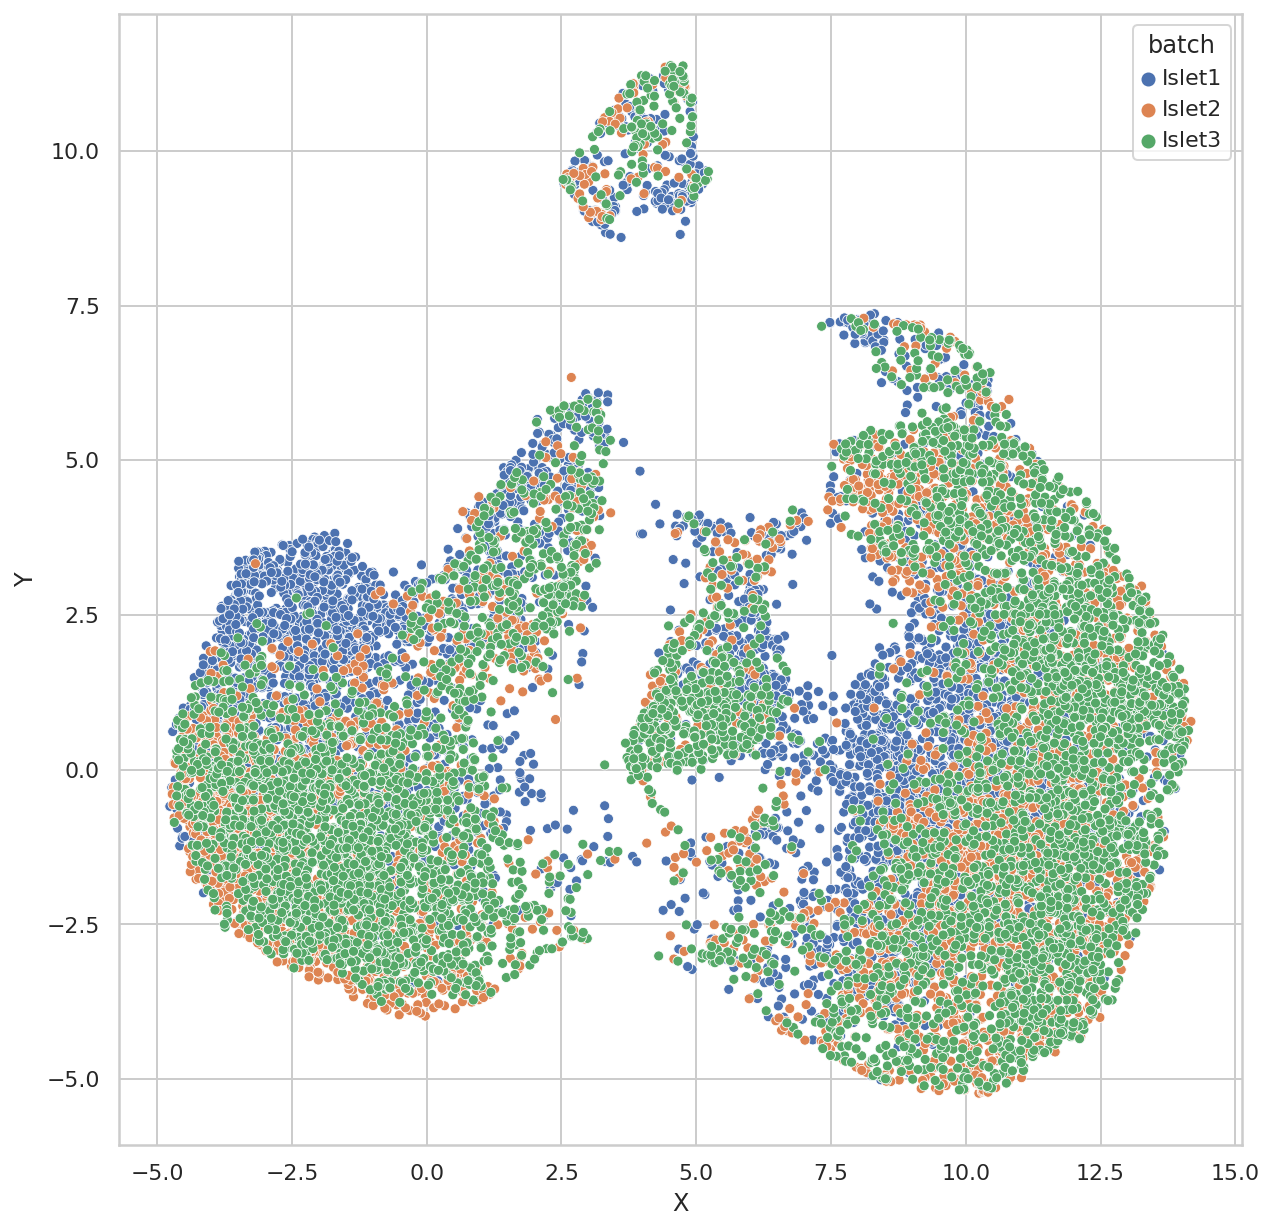

In [21]:
cell_type_sorted = sorted(list(set(atac_obs['cluster_name'].values)))
color_dict = dict(zip(cell_type_sorted,colPalette_celltypes))

%matplotlib inline
import seaborn as sns


#fig, axs = plt.subplots(ncols=1, figsize=(10,10), constrained_layout=True)
fig, axs = plt.subplots(ncols=1, figsize=(10,10), constrained_layout=False)
sns.set(rc={'figure.figsize':(10,10)},style='whitegrid')
sns.scatterplot(x="X", y="Y",
              hue="batch",
              data=df_umap,ax=axs,s=25)

In [16]:
sc.pp.neighbors(atac, n_neighbors=30,use_rep="X_PeakVI")
# compute the umap
sc.tl.umap(atac, min_dist=0.3)
# cluster the space (we use a lower resolution to get fewer clusters than the default)

In [17]:
sc.tl.leiden(atac, key_added="cluster_pvi", resolution=1.5)

/mnt/md1/home/gnovakovsky/.conda/envs/pytorch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cluster_name' as categorical
/mnt/md1/home/gnovakovsky/.conda/envs/pytorch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical


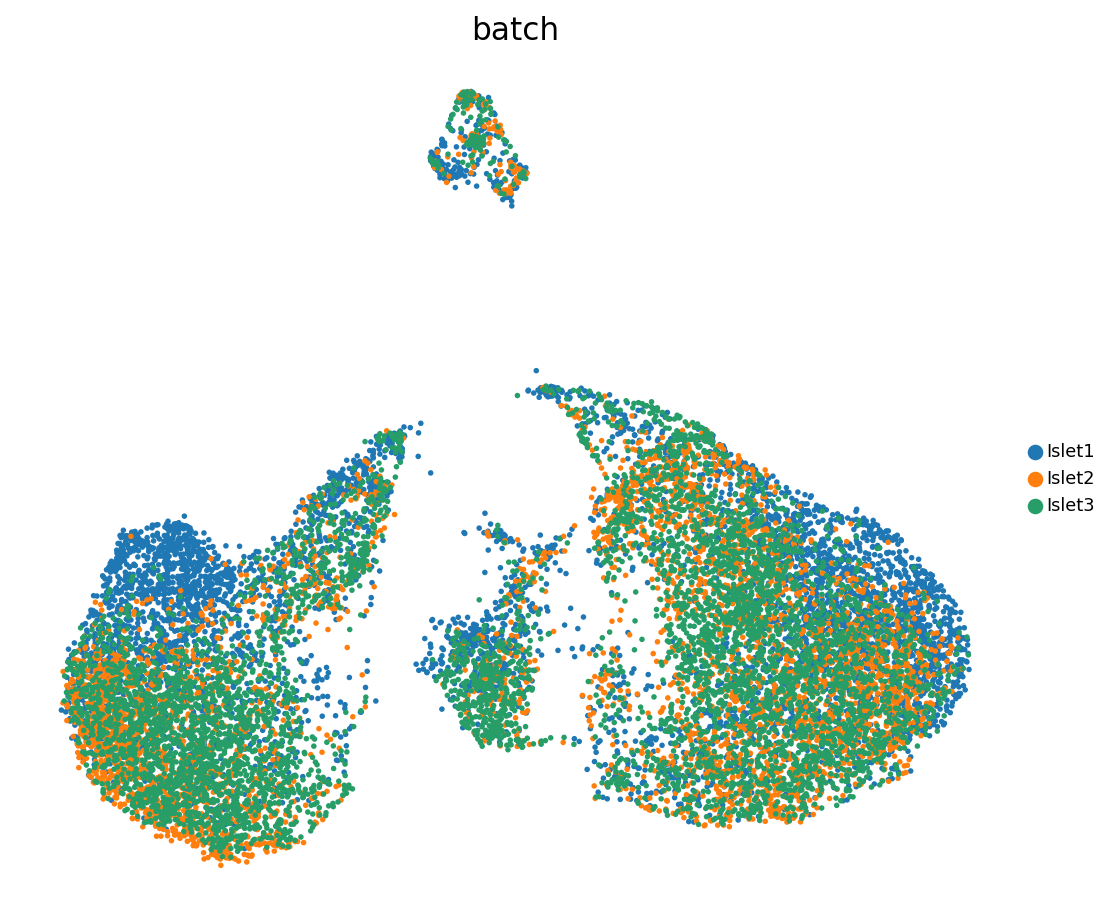

In [18]:
#sc.pl.umap(atac, color='cluster_name',size=25, legend_loc="on data",  legend_fontsize=8)
sc.pl.umap(atac, color='batch',size=25,   legend_fontsize=8)

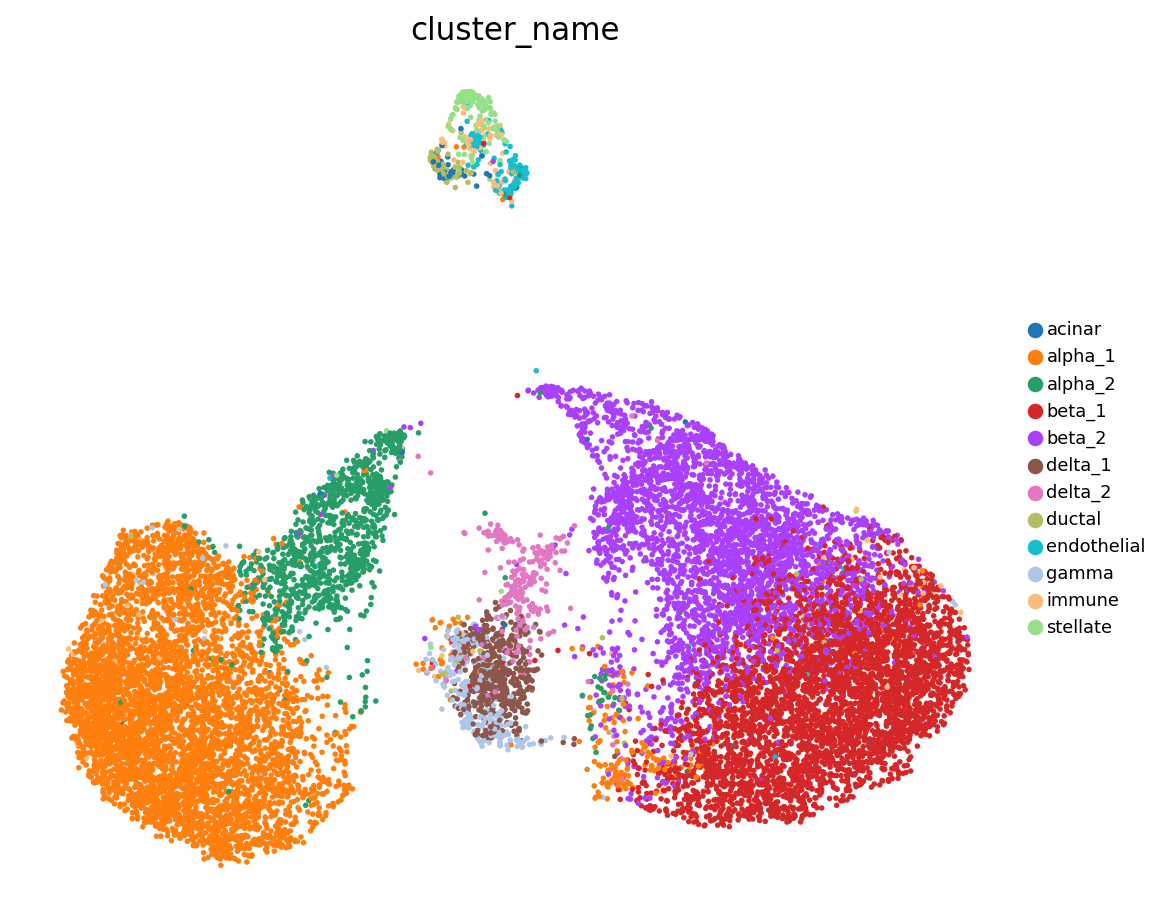

In [19]:
sc.pl.umap(atac, color='cluster_name',size=25,   legend_fontsize=8)

In [20]:
posterior = pvi.get_accessibility_estimates()

In [21]:
posterior.shape

(15298, 228873)

In [22]:
with open('acc_estimates_peakvi.npy', 'wb') as f:
    np.save(f,posterior)

In [ ]:
with open('acc_estimates_peakvi.npy', 'rb') as f:
    posterior = np.load(f)

In [23]:
df_atac = pd.DataFrame(posterior, columns = atac.var.index,index=atac.obs.index)

/mnt/md1/home/gnovakovsky/.conda/envs/pytorch_env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

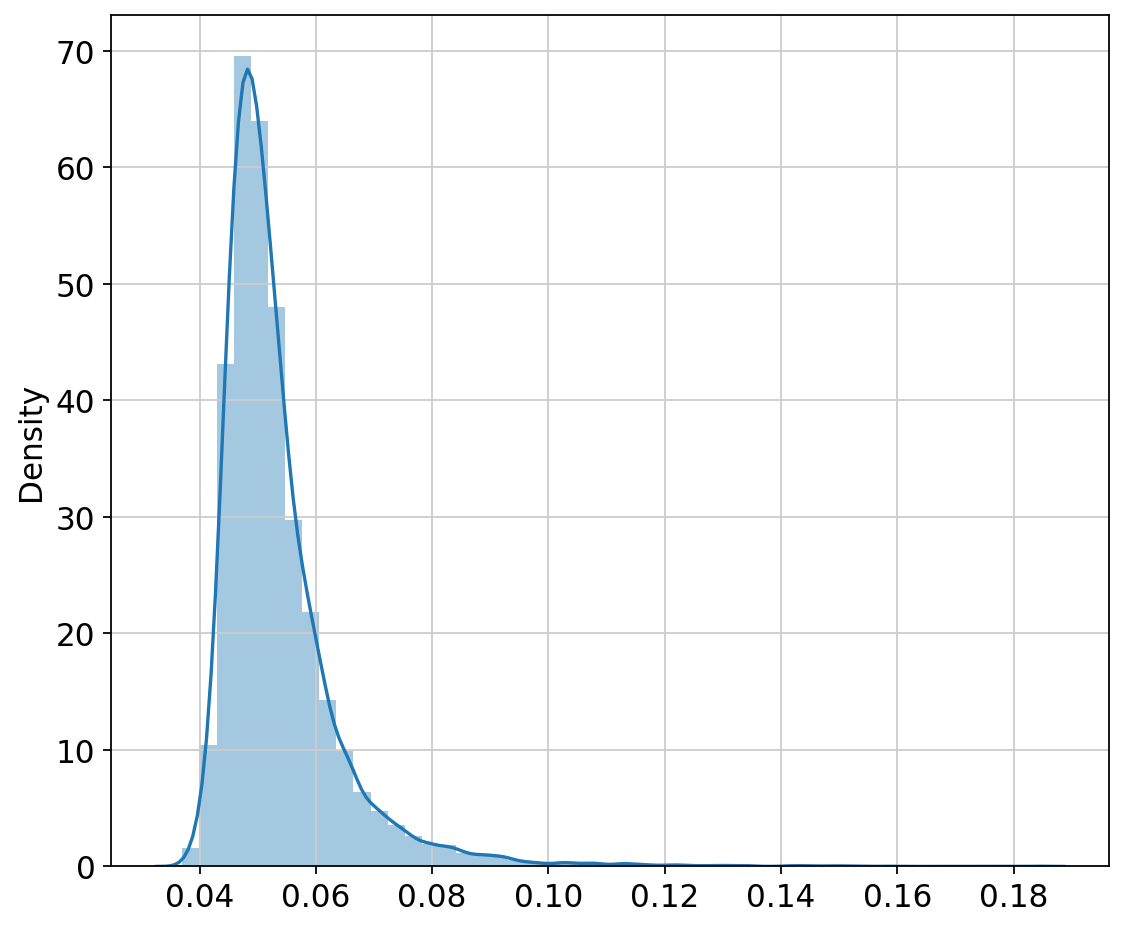

In [24]:
sns.distplot(df_atac.mean(axis=1))

In [25]:
df_atac['celltype'] = atac.obs['cluster_name'].values

In [26]:
df_atac.head()

peak_name,1:100009712-100010377,1:100014525-100015253,1:100017588-100018137,1:100023302-100023931,1:10002866-10003720,1:100056228-100056811,1:100064582-100064908,1:100065306-100065506,1:10010367-10010795,1:100110838-100111038,...,Y:7140595-7141174,Y:7141594-7142612,Y:7194218-7194599,Y:7212793-7213061,Y:7242668-7242868,Y:7263306-7263506,Y:7333176-7333627,Y:7395741-7396164,Y:7412234-7412477,celltype
#cell_id,,,,,,,,,,,,,,,,,,,,,
Islet1_AGACACCTAAGAGGCAAAGGAGTAGGCTC,0.040774,0.028109,0.031375,0.023872,0.105889,0.022559,0.000984,0.001569,0.030217,0.007560,...,0.040363,0.144731,0.003476,0.013195,0.000370,0.000385,0.007472,0.008660,0.008864,alpha_2
Islet1_AGACACCTAAGAGGCAAAGGAGTAGGTTG,0.062188,0.032029,0.022267,0.021102,0.303636,0.031572,0.001479,0.001260,0.025204,0.003159,...,0.015225,0.120651,0.000350,0.004438,0.000809,0.000127,0.002640,0.005802,0.009101,beta_2
Islet1_AGACACCTAAGAGGCAAAGGCTATATAGA,0.057460,0.015639,0.005418,0.041960,0.272053,0.086480,0.011275,0.014006,0.054507,0.033294,...,0.069025,0.331068,0.015513,0.009773,0.008506,0.000240,0.044405,0.006436,0.015590,immune
Islet1_AGACACCTAAGAGGCAACTGCATAGTACT,0.013143,0.020260,0.006522,0.003467,0.303814,0.001616,0.000561,0.001144,0.126171,0.004780,...,0.074381,0.225231,0.002511,0.008301,0.000143,0.000244,0.001417,0.002653,0.002977,alpha_1
Islet1_AGACACCTAAGAGGCACCTAGAGTAGGCG,0.118236,0.057939,0.002981,0.006649,0.180558,0.035528,0.001162,0.001051,0.053368,0.031297,...,0.073736,0.318713,0.000483,0.012871,0.000911,0.001691,0.002619,0.011234,0.004758,beta_1


In [27]:
from tqdm import tqdm

In [28]:
celltype_group = df_atac.groupby('celltype')

cell_types = []
num_peaks = len(atac.var.index)

mean_acc_arr = np.empty((0,num_peaks))
#sum_acc_arr = np.empty((0,num_peaks))
#median_acc_arr = np.empty((0,num_peaks))

for cell_type in df_atac.celltype.unique():
    a = celltype_group.get_group(cell_type).drop(columns='celltype').mean().values.reshape(1,-1)
    
    mean_acc_arr = np.concatenate((mean_acc_arr,a))
    cell_types.append(cell_type)

mean_acc_arr.shape

(12, 228873)

In [29]:
df_atac_training = pd.DataFrame(mean_acc_arr.T,columns = cell_types,index=atac.var.index)

In [30]:
# We use this for training CAMs
df_atac_training.head()

,alpha_2,beta_2,immune,alpha_1,beta_1,delta_2,delta_1,acinar,ductal,gamma,endothelial,stellate
peak_name,,,,,,,,,,,,
1:100009712-100010377,0.025972,0.140406,0.094703,0.020963,0.126555,0.072435,0.037665,0.089063,0.110462,0.034918,0.084784,0.186589
1:100014525-100015253,0.018623,0.071533,0.028600,0.026508,0.104760,0.019076,0.017249,0.013615,0.014350,0.020607,0.012025,0.012036
1:100017588-100018137,0.031992,0.032712,0.007027,0.004293,0.003657,0.036808,0.004231,0.007534,0.008008,0.003811,0.004625,0.011335
1:100023302-100023931,0.035797,0.027060,0.038204,0.005420,0.007367,0.061814,0.008533,0.048994,0.063749,0.005873,0.054482,0.151951
1:10002866-10003720,0.272739,0.212730,0.261435,0.225892,0.202386,0.220377,0.197521,0.286331,0.269792,0.217983,0.369146,0.329510


In [31]:
df_atac_training.to_csv('peaks_by_celltype_mean_peakvi.tsv',sep='\t')